# WK06- Python and sqlite - AnswerK

In [1]:
# standard includes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Python and Databases

Python can talk to any number of databases through different interfaces (https://wiki.python.org/moin/DatabaseInterfaces). This means that if we wanted or needed to, we could talk directly to MySQL, ORACLE, or even Microsoft SQL Server.

But sometimes, you don't need a full-fledged database server that can handle thousands of simultaneous users and gigs of data, like in this class. In these situations there is a database called "sqlite" (https://sqlite.org/about.html) that does just about everything and it conveniently included with Python.

SQL in sqlite is very similiar to SQL for MySQL, but there are some exceptions and differences. The relational concepts are all the same though.

In [2]:
# import the sqlite api
import sqlite3

Each sqlite database really just a file. The API talks to the file to allow you to do SQL opperations on the data the file contains. And just like in INST327, each database can contain any number of tables and each of those tables can contain any number of rows.

We connect to a database by telling sqlite where the database file is located.

In [3]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect("data/portal_mammals.sqlite")

Then we need to open a "cursor." This is exactly like cursors we have to use in MySQL when dealing with transactions.

In [4]:
cur = con.cursor()

And the SQL looks very similar:

In [5]:
cur.execute('SELECT * FROM species LIMIT 5;')

In [6]:
for row in cur.execute('SELECT * FROM species LIMIT 5;'):
    print(row)

('AB', 'Amphispiza', 'bilineata', 'Bird')
('AH', 'Ammospermophilus', 'harrisi', 'Rodent-not censused')
('AS', 'Ammodramus', 'savannarum', 'Bird')
('BA', 'Baiomys', 'taylori', 'Rodent')
('CB', 'Campylorhynchus', 'brunneicapillus', 'Bird')


And of course, we should close our database connection when we are done with it.

In [7]:
con.close()

This can get tricky in Jupyter Notebooks because you can easily close a db connection before you are done with it. The error message is helpful though.

In [8]:
#for row in cur.execute('SELECT * FROM species LIMIT 5;'):
#    print(row)

In [9]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect("data/portal_mammals.sqlite")

cur = con.cursor()

You can get all of the rows at once returned as a list of tuples by using the fetchall() method. 

In [10]:
# Return all results of query
cur.execute('SELECT * FROM plots WHERE plot_type="Control"')
cur.fetchall()

[(2, 'Control'),
 (4, 'Control'),
 (8, 'Control'),
 (11, 'Control'),
 (12, 'Control'),
 (14, 'Control'),
 (17, 'Control'),
 (22, 'Control')]

Or just get the first row (useful when you know you are only getting a single row back).

In [11]:
# Return first result of query
cur.execute('SELECT COUNT(*) as bird_count FROM species WHERE taxa="Bird"')
cur.fetchone()

(13,)

In [12]:
# Be sure to close the connection
con.close()

## Pandas and sqlite

Most handily, we can easily get data from the database into a Pandas DataFrame. While we are using sqlite in class, be sure to remember than many Python database interfaces will work with this function. This means that you can work directly with data from your company's production database and to do really powerful analyses. Just remember the limitations of working on data that might be changing while you are working on it...

In [13]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("data/portal_mammals.sqlite")
df = pd.read_sql_query("SELECT * from surveys", con)
con.close()

Notice that the DataFrame still has the data in it even after we close the database connection.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35549 entries, 0 to 35548
Data columns (total 8 columns):
record_id    35549 non-null int64
month        35549 non-null int64
day          35549 non-null int64
year         35549 non-null int64
plot         35549 non-null int64
species      34786 non-null object
sex          33043 non-null object
wgt          32283 non-null float64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.2+ MB


## Storing Data in SQLITE

Sometimes we have data that makes more sense to store in a database than it does in another format. For example, those particularly nasty XML files from the NSF. What if we want to store them in a way that we can actually use in the future?

In [15]:
from lxml import etree
nsf_funding = etree.parse('data/NSFFundingRateHistory.xml')

The function below uses the SAX-like features of LXML to avoid having to loop through the tree. 

We just have to be a little more careful in our planning in order to do this successfully. This function is the result of me looking at the many different ways that all of you did it and stealing the best ideas.

In [16]:
def parseFunding(xml_obj):
    doc = []
    row = {}
    for element in xml_obj.getiterator():
        #print(element.tag, element.attrib)
        if element.tag == 'IDENTIFICATION':
            orgdir = element.attrib.get('ABBR')
            year = element.attrib.get('YEAR')
            funding = element.attrib.get('FILTER')
        if element.tag in ['DIV', 'DIR']:
            # the div tags hold the division information, the dir tag holds the sum of all the div tag values, so we can calculate that.
            # we all don't need to save "rate" since that is a percentage that can be calculated from award divided by action
            row = {}
            row['dir'] = orgdir
            row['year'] = pd.to_numeric(year)
            row['funding'] = funding
            row['div'] = element.attrib.get('NAME')
            row['actions'] = pd.to_numeric(element.attrib.get('ACTIONS'), errors='coerce')
            row['awards'] = pd.to_numeric(element.attrib.get('AWARDS'), errors='coerce')
            row['rate'] = pd.to_numeric(element.attrib.get('RATE').strip()[:-1])/100
            doc.append(row)
    return pd.DataFrame(doc)

In [17]:
nsf_rate = parseFunding(nsf_funding.getroot())

In [18]:
nsf_rate.head()

,actions,awards,dir,div,funding,rate,year
0,6204,955,ENG,ENG,RESEARCH GRANTS,0.15,2004
1,1894,286,ENG,CBET,RESEARCH GRANTS,0.15,2004
2,2380,351,ENG,CMMI,RESEARCH GRANTS,0.15,2004
3,1304,187,ENG,ECCS,RESEARCH GRANTS,0.14,2004
4,368,63,ENG,EEC,RESEARCH GRANTS,0.17,2004


And magically we have a DataFrame, but that was gross and we don't ever want to do it again.

Also, this has a distinctly relational feel to it, particularly if we parsed out all of the data from the XML... For example Directorates have Divisions and Divisions are usually the ones that award grant money to researchers. But does the DIR tag, which will show up as a row where the dir and div values are the same, only contain a roll-up? Probably best to check before making that assumption. We could do that in Pandas, but I like SQL.

We can easily just dump a DataFrame to a sql database using the 'to_sql' method. But this doesn't make it a good database format. The table created isn't normalized, it is just a direct translation of the DataFrame into a single table.

In [19]:
db = sqlite3.connect('data/nsf.sqlite')
nsf_rate.to_sql("nsf_funding_rate", db, if_exists="replace")
db.close()

Now that it is saved in a database (the 'nsf.sqlite' file),  I can work with it in a way that is a little more comfortable for me.

In [20]:
# calculate the aggregate, dropping the numbers from the dir tag (where dir == div)
nsf_agg_query = '''
SELECT year, dir, SUM(actions) as sum_actions, SUM(awards) as sum_awards
FROM nsf_funding_rate 
WHERE dir <> div
GROUP BY year, dir
ORDER BY year, dir
'''

In [21]:
# get just what was in the dir tags (where dir == div)
nsf_dir_query = '''
SELECT year, dir, actions, awards, rate
FROM nsf_funding_rate 
WHERE dir == div
ORDER BY year, dir
'''

In [22]:
nsf_agg_join_query = '''
SELECT *
FROM (SELECT year, dir, SUM(actions) actions, SUM(awards) awards, rate
FROM nsf_funding_rate 
WHERE dir <> div
GROUP BY year, dir
ORDER BY year, dir) A
JOIN (SELECT year, dir, actions, awards, rate
FROM nsf_funding_rate 
WHERE dir == div
ORDER BY year, dir) B 
ON B.year = A.year AND B.dir = A.dir
'''

In [23]:
db = sqlite3.connect('data/nsf.sqlite')
cur = db.cursor()
nsf_agg = pd.read_sql_query(nsf_agg_query, db)
nsf_dir = pd.read_sql_query(nsf_dir_query, db)
nsf_join = pd.read_sql_query(nsf_agg_join_query, db)
db.close()

In [24]:
nsf_agg.head()

,year,dir,sum_actions,sum_awards
0,2004,BIO,4824,925
1,2004,CISE,6109,846
2,2004,EHR,4302,805
3,2004,ENG,6204,955
4,2004,GEO,4363,1319


In [25]:
nsf_dir.head()

,year,dir,actions,awards,rate
0,2004,BIO,4824,925,0.19
1,2004,CISE,6111,846,0.14
2,2004,EHR,4303,805,0.19
3,2004,ENG,6204,955,0.15
4,2004,GEO,4363,1319,0.30


In [26]:
nsf_join.head()

,year,dir,actions,awards,rate,year,dir,actions,awards,rate
0,2004,BIO,4824,925,0.18,2004,BIO,4824,925,0.19
1,2004,CISE,6109,846,0.10,2004,CISE,6111,846,0.14
2,2004,EHR,4302,805,0.50,2004,EHR,4303,805,0.19
3,2004,ENG,6204,955,0.26,2004,ENG,6204,955,0.15
4,2004,GEO,4363,1319,0.34,2004,GEO,4363,1319,0.30


The look similar, but are they the same? Lets merge them to compare...

In [27]:
df = pd.merge(nsf_agg, nsf_dir)

In [28]:
df.head()

,year,dir,sum_actions,sum_awards,actions,awards,rate
0,2004,BIO,4824,925,4824,925,0.19
1,2004,CISE,6109,846,6111,846,0.14
2,2004,EHR,4302,805,4303,805,0.19
3,2004,ENG,6204,955,6204,955,0.15
4,2004,GEO,4363,1319,4363,1319,0.30


Here we write a function to compare the values in each column to see if they match. Remember that sum_awards and sum_actions are our aggregates from calculating what the div tags held and that actions and awards are the numbers that were contained in the dir tag.

In [29]:
def compare_rows(row):
    return row['sum_awards'] == row['awards'] and row['sum_actions'] == row['actions']

df['matches'] = df.apply(compare_rows, axis=1)

We only have to look at the first 5 rows to see that the answer is that they are not the same. 

This seems to indicate that occasionally the Directorates directly funded research without going through one of their Divisions.

In [30]:
df['matches'][0:5]

0     True
1    False
2    False
3     True
4     True
Name: matches, dtype: bool

In [31]:
df.head()

,year,dir,sum_actions,sum_awards,actions,awards,rate,matches
0,2004,BIO,4824,925,4824,925,0.19,True
1,2004,CISE,6109,846,6111,846,0.14,False
2,2004,EHR,4302,805,4303,805,0.19,False
3,2004,ENG,6204,955,6204,955,0.15,True
4,2004,GEO,4363,1319,4363,1319,0.30,True


And we didn't save the rate because we can easily calculate a percentage.

In [32]:
df['percent'] = df['awards'] / df['actions']
df['sum_perc'] = df['sum_awards'] / df['sum_actions'] 

In [33]:
df.head()

,year,dir,sum_actions,sum_awards,actions,awards,rate,matches,percent,sum_perc
0,2004,BIO,4824,925,4824,925,0.19,True,0.191750,0.191750
1,2004,CISE,6109,846,6111,846,0.14,False,0.138439,0.138484
2,2004,EHR,4302,805,4303,805,0.19,False,0.187079,0.187122
3,2004,ENG,6204,955,6204,955,0.15,True,0.153933,0.153933
4,2004,GEO,4363,1319,4363,1319,0.30,True,0.302315,0.302315


Seems like 2009 was a good year for research funding. I wonder if that was because the NSF had a really big budget that year?

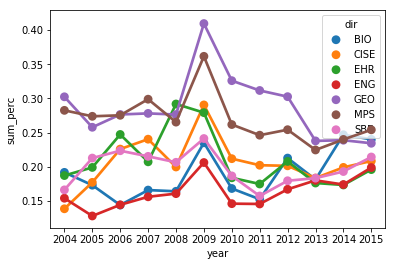

In [34]:
sns.pointplot(data=df, x="year", y="sum_perc", hue="dir")

# Q1 SAVE THE BUDGET TO SQL

Here is a function I wrote to create a DataFrame from the budget XML.

Write the code to save that DataFrame into a SQL table.

In [36]:
pd.to_numeric('   $1,000.08   '.strip().replace(',','')[1:])

1000.08

In [37]:
def parseBudget(xml_obj):
    doc = []
    row = {}
    year = ''
    dollars = ''
    for element in xml_obj.getiterator():
        #print(element.tag, element.attrib)
        if element.tag[:2] == 'FY':
            year = element.tag[2:6]
        if element.tag == 'CurrentDollars':
            dollars = 'current'
        if element.tag == 'ConstantDollars':
            dollars = 'constant'
        if element.tag in ['RRA', 'EHR', 'ARI', 'MREFC', 'AOAM', 'OIG', 'NSB', 'NSFTotal']:
            row = {}
            row['year'] = int(year)
            row['dollars'] = dollars
            row['source'] = element.tag
            row['value'] = pd.to_numeric(element.text.strip().replace(',','')[1:])
            doc.append(row)
    return pd.DataFrame(doc)

In [38]:
nsf_budget = etree.parse('data/NSFBudgetHistory.xml')
budget_df = parseBudget(nsf_budget.getroot())

In [39]:
# Your code here for Q1
db = sqlite3.connect('data/nsf.sqlite')
budget_df.to_sql('nsf_budget', db, if_exists="replace")

# Q2 Get the total NSF budget per year

Now that you saved that into a table. Write code that uses SQL to select the constant dollars for the total NSF budget per year and saves the resulting data into a DataFrame. 

In [40]:
# Your code here for Q2
nsf_budget = pd.read_sql_query('SELECT year, value FROM nsf_budget WHERE dollars = \'constant\' AND source = \'NSFTotal\'', db)
db.close()

# Q3
Can you tell if the reason the funding rates were so high in 2009 were because of a bigger budget? 

(I would first calculate the total funding rate per year and tcombing that with the total budget for the year.. 

In [41]:
# Your code here for Q3

nsf_budget.set_index('year', inplace=True)
nsf_budget.head()

,value
year,
1951,1.18
1952,26.13
1953,32.70
1954,58.08
1955,90.44


In [42]:
nsf_dir.set_index('year', inplace=True)

In [43]:
agg_dir = nsf_dir.groupby('year').sum()

In [44]:
agg_dir['rate'] = agg_dir['awards'] / agg_dir['actions']

In [45]:
agg_dir.head()

,actions,awards,rate
year,,,
2004,35033,7043,0.201039
2005,34101,6824,0.200111
2006,33806,7242,0.214222
2007,36474,8069,0.221226
2008,35810,7769,0.216951


In [46]:
trend_df = nsf_budget.join(agg_dir)

In [47]:
trend_df.tail()

,value,actions,awards,rate
year,,,,
2013,7256.77,41501.0,8167.0,0.196790
2013,1.22,41501.0,8167.0,0.196790
2013,7257.99,41501.0,8167.0,0.196790
2014,7388.71,40593.0,8430.0,0.207671
2015,7535.60,41849.0,9237.0,0.220722


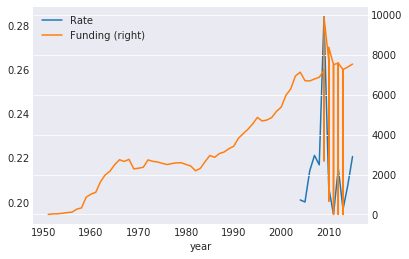

In [48]:
sns.set_style("darkgrid")
trend_df.rate.plot(label="Rate", legend=True)
trend_df.value.plot(secondary_y=True, label="Funding", legend=True)
plt.show()

In [49]:
df = trend_df.dropna()
df.head()

,value,actions,awards,rate
year,,,,
2004,7130.44,35033.0,7043.0,0.201039
2005,6703.92,34101.0,6824.0,0.200111
2006,6688.25,33806.0,7242.0,0.214222
2007,6787.32,36474.0,8069.0,0.221226
2008,6875.63,35810.0,7769.0,0.216951


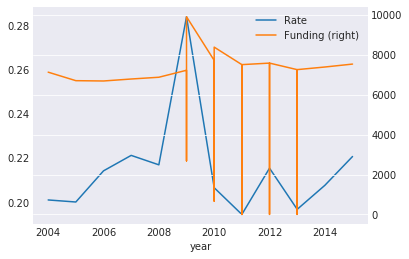

In [51]:
df.rate.plot(label="Rate", legend=True)
df.value.plot(secondary_y=True, label="Funding", legend=True)
plt.show()